# Big Data
## Traffic Counts (2022)

- Created June 2024 to compare 2022 traffic counts  
- Caltrans' latest available AADT counts are from Federal FY 2022 (Ending September 30, 2022)

## Focusing on Hwy 50

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import folium
from folium import plugins
from folium.plugins import MarkerCluster
from io import BytesIO
import base64

In [2]:
# Identify path to Google Cloud
path = "gs://calitp-analytics-data/data-analyses/big_data/compare_traffic_counts/3_ct_hwy50/"
path1 = "gs://calitp-analytics-data/data-analyses/big_data/compare_traffic_counts/3_rep_hwy50/"


In [3]:
# Name the dataset(s)
ct_df01 = f'{path}ct-hwy50-traffic-counts-2022.csv' # Caltrans data
rep_df01 = f'{path1}replica-hwy50corridorfall2022-06_10_24-network_link_layer.csv' # Replica data

In [4]:
# create a function to import the data from a csv file
def getData(path):
    # Suppress warning
    warnings.filterwarnings("ignore")
    
    # reads in the data from a .csv file
    df = pd.read_csv(path)
    return df

In [5]:
# Pull in the data
ct_df01 = getData(ct_df01)
rep_df01 = getData(rep_df01)

In [6]:
# Create a function to remove spaces and make header characters lowercase
def clean_headers(df):
    cleaned_columns = []
    for column in df.columns:
        cleaned_column = column.replace(" ", "").lower()
        cleaned_columns.append(cleaned_column)
    df.columns = cleaned_columns
    return df

In [7]:
# Clean the headers using the clean_headers function
ct_df01 = clean_headers(ct_df01)
rep_df01 = clean_headers(rep_df01)

In [8]:
# Adding a column for the federal fiscal year
ct_df01['year'] = '2022'
rep_df01['year'] = '2022'

### Caltrans Traffic Census Data
- Caltrans Traffic Census counts follow the Federal Fiscal Year (October 1, 2021 - September 30, 2022)

In [9]:
# Create a subset from the Caltrans Traffic Census DataFrame
ct_df01 = ct_df01[['year', 'objectid*', 'district', 'county', 'route', 'pm', 'location_description', 'back_aadt', 'ahead_aadt']]

In [10]:
# Create a function to visualize the 'back_aadt' values

def visualize_ct_back_aadt(df, county_order=None):
    """
    Visualizes the Caltrans Traffic Census count in the 'back_aadt' column organized by the values in the County ['county'] and Post Mile ['pm'] columns using a bar chart. 
    
    Paramters:
    df (pd.DataFrame): The DataFrame containing 'county', 'pm', and 'back_aadt' columns.
    
    Returns:
    None
    """
    
    # Suppress warning
    warnings.filterwarnings("ignore")
    
    # Order the visualization by County
    
    county_order = ('SAC', 'ED')
    
    if county_order:
        df['county'] = pd.Categorical(df['county'], categories=county_order, ordered=True)
        df = df.sort_values(['county', 'pm'])
    
    # Grouping the data by 'County' and 'Post Mile'
    grouped = df.groupby(['county', 'pm']).mean().reset_index()
    
    # Plotting setup
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Generate a unique set of colors for "Ahead" and "Back" AADT volumes
    ahead_color = 'grey'
    back_color = 'blue'
    
    # Define bar width and positions
    bar_width = 0.25
    county_starts = []
    county_labels = []
    tick_positions = []
    
    # Calculate the total number of postmiles
    total_postmiles = grouped.shape[0]
    
    # Calculate the spacing
    pm_spacing = bar_width * 3
      
    current_position = 0
    
    for county in grouped['county'].unique():
        county_data = grouped[grouped['county'] == county]
        postmiles = county_data['pm'].unique()
        
        num_postmiles = len(postmiles)
             
        # Calculate the start position for the County label
        county_starts.append(current_position + (len(postmiles) * pm_spacing) / 2 - pm_spacing / 2)
        county_labels.append(county)
        
        for pm in postmiles:
            pm_data = county_data[county_data['pm'] == pm]
            ahead_avg = pm_data['ahead_aadt'].values[0]
            back_avg = pm_data['back_aadt'].values[0]
            
            ax.bar(current_position, ahead_avg, bar_width, label=f'Ahead AADT - {pm}', color=ahead_color)
            ax.bar(current_position + bar_width, back_avg, bar_width, label=f'Back AADT - {pm}', color=back_color)
            
            tick_positions.append(current_position + bar_width)
            current_position += pm_spacing
            
        current_position += pm_spacing # Add space between cities
                
    # Adding title and labels
    ax.set_title('Caltrans Traffic Census Counts - Hwy 50')
    ax.set_xlabel('Post Mile')
    ax.set_ylabel('AADT')
    ax.set_xticks(county_starts)
    ax.set_xticklabels(county_labels, rotation=45)
    
    # Adding a simplified legend
    ahead_bar = ax.bar(0, 0, color=ahead_color, label='Ahead AADT')
    back_bar = ax.bar(0, 0 , color=back_color, label='Back AADT')
    ax.legend(handles=[ahead_bar, back_bar])
    
    # Adding grid
    ax.grid(True)
    
    # Adjusting layout to make room for the legend
    plt.tight_layout()
    
    # Showing the plot
    plt.show()

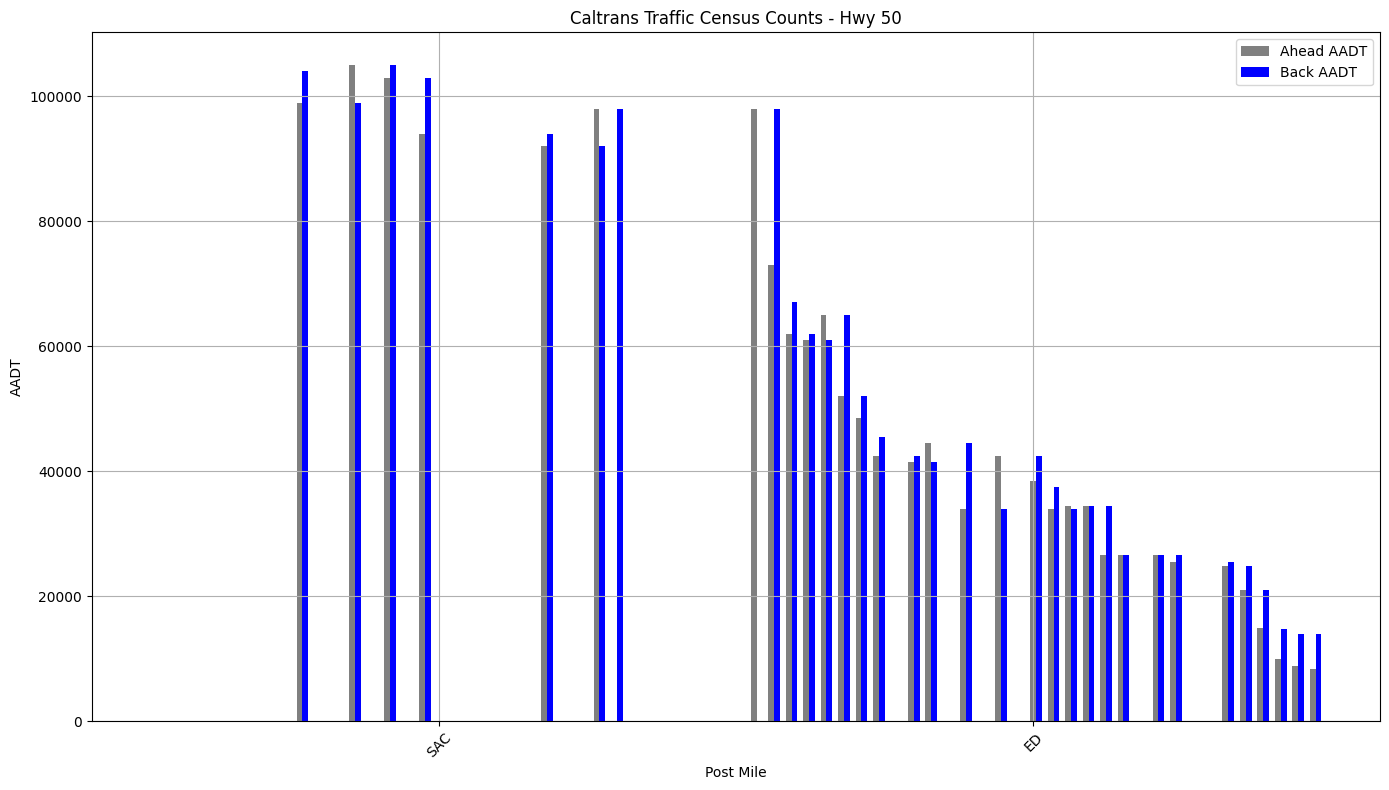

In [11]:
# Visualizing Caltrans AADT data
visualize_ct_back_aadt(ct_df01)

In [12]:
# Create a function to visualize the 'back_aadt' values
# Only show values for the following locations: Sunrise Boulevard, Prairie City Road, Latrobe Road, Cameron Park, Missouri Flat Road, (Placerville, Mosquito Road Overhead (Broadway))
# (Junction Old Highway, Camino, West), SLy Park Road, Icehouse Road, Echo Lake Road

def visualize_ct_back_aadt_filtered(df, county_order=None):
    """
    Visualizes the Caltrans Traffic Census count in the 'back_aadt' column organized by the values in the County ['county'] and Post Mile ['pm'] columns using a bar chart. 
    
    Paramters:
    df (pd.DataFrame): The DataFrame containing 'county', 'pm', and 'back_aadt' columns.
    
    Returns:
    None
    """
    
    # Suppress warning
    warnings.filterwarnings("ignore")
    
    # Filter the DataFrame based on ['location_description'] values
    filtered_locations = ["NIMBUS ROAD", 
                          "PRAIRIE CITY ROAD", 
                          "LATROBE ROAD", 
                          "CAMERON PARK", 
                          "MISSOURI FLAT ROAD", 
                          "PLACERVILLE, MOSQUITO ROAD OVERHEAD (BROADWAY)",
                          "JUNCTION OLD HIGHWAY, CAMINO, WEST", 
                          "SLY PARK ROAD", 
                          "ICEHOUSE ROAD", 
                          "ECHO LAKE ROAD"]
    df = df[df['location_description'].isin(filtered_locations)]  
        
    # Order the visualization by County
    county_order = ('SAC', 'ED')
    
    if county_order:
        df['county'] = pd.Categorical(df['county'], categories=county_order, ordered=True)
        df = df.sort_values(['county', 'pm'])
    
    # Grouping the data by 'County' and 'Post Mile'
    grouped = df.groupby(['county', 'pm']).mean().reset_index()
    
    # Plotting setup
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Generate a unique set of colors for "Ahead" and "Back" AADT volumes
    ahead_color = 'grey'
    back_color = 'blue'
    
    # Define bar width and positions
    bar_width = 0.25
    county_starts = []
    county_labels = []
    tick_positions = []
    
    # Calculate the total number of postmiles
    total_postmiles = grouped.shape[0]
    
    # Calculate the spacing
    pm_spacing = bar_width * 3
      
    current_position = 0
    
    for county in grouped['county'].unique():
        county_data = grouped[grouped['county'] == county]
        postmiles = county_data['pm'].unique()
        
        num_postmiles = len(postmiles)
             
        # Calculate the start position for the County label
        county_starts.append(current_position + (len(postmiles) * pm_spacing) / 2 - pm_spacing / 2)
        county_labels.append(county)
        
        for pm in postmiles:
            pm_data = county_data[county_data['pm'] == pm]
            ahead_avg = pm_data['ahead_aadt'].values[0]
            back_avg = pm_data['back_aadt'].values[0]
            
            ax.bar(current_position, ahead_avg, bar_width, label=f'Ahead AADT - {pm}', color=ahead_color)
            ax.bar(current_position + bar_width, back_avg, bar_width, label=f'Back AADT - {pm}', color=back_color)
            
            tick_positions.append(current_position + bar_width)
            current_position += pm_spacing
            
        current_position += pm_spacing # Add space between cities
                
    # Adding title and labels
    ax.set_title('Caltrans Traffic Census Counts - Hwy 50')
    ax.set_xlabel('Post Mile')
    ax.set_ylabel('AADT')
    ax.set_xticks(county_starts)
    ax.set_xticklabels(county_labels, rotation=45)
    
    # Adding a simplified legend
    ahead_bar = ax.bar(0, 0, color=ahead_color, label='Ahead AADT')
    back_bar = ax.bar(0, 0 , color=back_color, label='Back AADT')
    ax.legend(handles=[ahead_bar, back_bar])
    
    # Adding grid
    ax.grid(True)
    
    # Adjusting layout to make room for the legend
    plt.tight_layout()
    
    # Showing the plot
    plt.show()

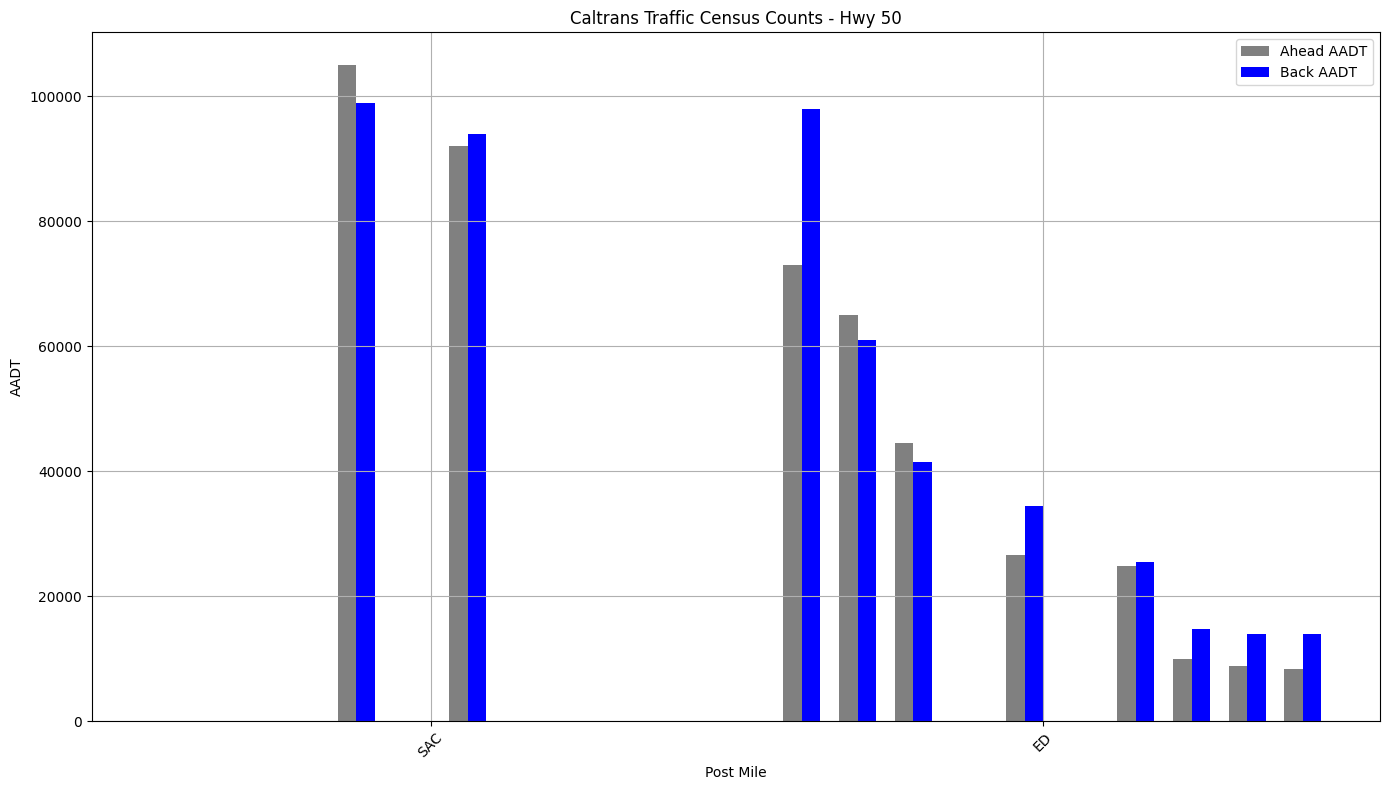

In [13]:
# Visualizing Caltrans AADT data
visualize_ct_back_aadt_filtered(ct_df01)

### Replica Traffic Counts
- Replica Traffic Counts are from Calendar Year 2022 (January 1, 2022 - December 31, 2022)

In [14]:
# Group by 'osmid', 'startlat', 'startlon'
rep_df01 = rep_df01.groupby(['osmid', 'networklinkid', 'direction', 'startlat', 'startlon'], as_index=False).agg(
    total_trip_count=pd.NamedAgg(column='trip_count', aggfunc='sum'),
    record_count=pd.NamedAgg(column='osmid', aggfunc='count')
)

# Calculate the average widget count per location
rep_df01['average_trip_count'] = rep_df01['total_trip_count']/rep_df01['record_count']

In [15]:
# Create a function to filter the data by OSM Segment IDs
# Filter the DataFrame based on ['location_description'] values
def filter_by_osmid(df):
    filtered_locations = [586346518, 
                          972301994,
                          972218036,
                          974291696,
                          972456575,
                          117518837,
                          39563171,
                          39563169,
                          950257855,
                          39575139,
                          91958374,
                          91958542,
                          180997578,
                          717270766,
                          117001918,
                          26921699,
                          401651191,
                          918799808,
                         ]
    df = df[df['osmid'].isin(filtered_locations)]  
    
    return df

In [16]:
# Create a filter by Network Link ID ['networklinkid']
def filter_by_networklinkid(df):
    filtered_locations = [6318569418755860454, # Nimbus Road East
                          4919446025123668139, # Nimbus Road West
                          10164004687761220118, # Prairie City Road West
                          473377144358464128, # Prairie City Road East
                          6763177671419507974, # Latrobe West
                          13282593593483289893, # Latrobe East
                          15468398035972853890, # Cameron Park West
                          13239198527686004252, # Cameron Park East
                          16245877946723553755, # Missouri Flat Road West
                          17839000377633739362, # Missouri Flat Road East
                          15331263866982114070, # Mosquito Road West
                          658632816435451376, # Mosquito Road East
                          16164510546711360006, # Camino West
                          17049649116298182417, # Camino East
                          6672200355374038345, # Sly Park West
                          17946628261172048104, # Sly Park East
                          1551750833300929677, # Ice House West
                          11949881834776692762, # Ice House East
                          8573086625371824039, # Echo West
                          14354786728023397668, # Echo East
                         ]
    df = df[df['networklinkid'].isin(filtered_locations)]  
    
    return df

In [17]:
rep_df01_filtered = filter_by_networklinkid(rep_df01)

In [18]:
rep_df01_filtered

,osmid,networklinkid,direction,startlat,startlon,total_trip_count,record_count,average_trip_count
0,26921699,6672200355374038345,West,38.761100,-120.565545,10664,1,10664.0
1,26921699,17946628261172048104,East,38.761050,-120.567790,10187,1,10187.0
17,39563169,15468398035972853890,West,38.659623,-120.970145,56993,1,56993.0
19,39563171,13239198527686004252,East,38.659388,-120.965366,63640,1,63640.0
42,39575139,16245877946723553755,West,38.708918,-120.844179,51529,1,51529.0
53,91958374,658632816435451376,East,38.731327,-120.787615,30201,1,30201.0
55,91958542,15331263866982114070,West,38.731810,-120.790432,39559,1,39559.0
84,117518837,6763177671419507974,West,38.652886,-121.070970,66161,1,66161.0
124,180997578,17049649116298182417,NorthEast,38.734249,-120.670156,20029,1,20029.0
144,401651191,1551750833300929677,West,38.768729,-120.446215,10104,1,10104.0


In [19]:
# a function to display the OSMID trip totals on a map
def create_aadt_map(df):
    # Initialize the map centered around the mean latitude and longitude
    m = folium.Map(location=[df['startlat'].mean(), df['startlon'].mean()], zoom_start=11)
    
    # MarkCluster is used to group nearby markers together
    # This helps in reducing clutter when many markers are close to each other
    marker_cluster = MarkerCluster().add_to(m)
    
    for idx, row in df.iterrows():
        popup_text = f"OSMID: {row['osmid']}<br>AADT: {row['average_trip_count']:.2f}"
        folium.Marker(
            location=[row['startlat'], row['startlon']],
            popup=popup_text
        ).add_to(marker_cluster)
    
    return m

In [20]:
rep_df01_map = create_aadt_map(rep_df01)
rep_df01_map.save('hwy50_aadt_map.html')

In [21]:
rep_df01_filtered_map = create_aadt_map(rep_df01_filtered)
rep_df01_filtered_map.save('hwy50_aadt_map_filtered.html')

#### Replica Map
- Click on the HTML document to open the Replica Map